# Лабораторная на кластеризацию ||

В ходе этой работы мы проведём кластеризацию на реальных данных

## Импортируем библиотеки

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Получаем данные и проводим анализ

### Скачиваем файл с данными по банкам и закидываем его в pandas

In [4]:
df = pd.read_csv('./data/bank-additional-full.csv', sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Предобработаем данные

In [5]:
# Разделим данные на категориальные и числовые
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                  'euribor3m', 'nr.employed']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Обработаем пропуски и заменим 'unknown' на наиболее частое значение
for col in categorical_cols:
    if (df[col] == 'unknown').sum() > 0:
        mode_value = df[col][df[col] != 'unknown'].mode()[0]
        df[col] = df[col].replace('unknown', mode_value)

# Заменим целевую переменную на числа (для простоты)
le = LabelEncoder()
df['y_encoded'] = le.fit_transform(df['y'])

# Проведём One-Hot кодирование для категориальных признаков
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Стандартизируем числовые признаки
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

### Проведём кластеризацию на числовых признаках

#### Методом локтя и силуэтным найдём кол-во кластеров

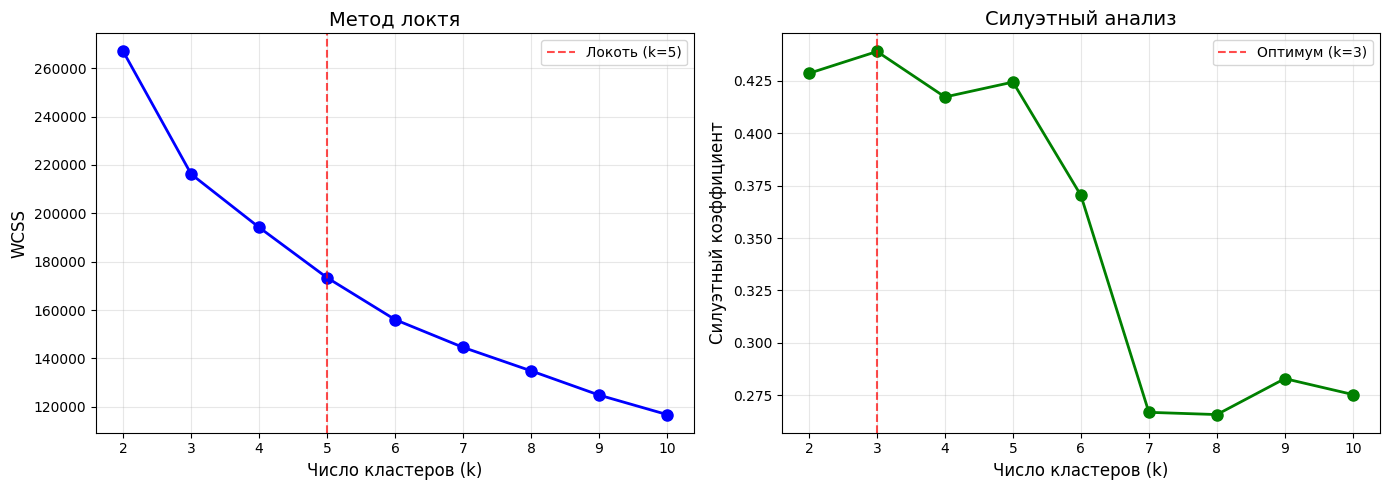

Оптимальное кол-во кластеров: 3


In [6]:
X_numerical = df_encoded[numerical_cols].copy()

# Проведём метод локтя разными методами
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_numerical)
    wcss.append(kmeans.inertia_)

    labels = kmeans.labels_
    if len(np.unique(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_numerical, labels))
    else:
        silhouette_scores.append(0)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров (k)', fontsize=12)
axes[0].set_ylabel('WCSS', fontsize=12)
axes[0].set_title('Метод локтя', fontsize=14)
axes[0].grid(True, alpha=0.3)

wcss_array = np.array(wcss)
first_diff = np.diff(wcss_array)
second_diff = np.diff(first_diff)
elbow_point = np.argmax(np.abs(second_diff)) + 3
optimal_k_elbow = k_range[elbow_point]

axes[0].axvline(x=optimal_k_elbow, color='r', linestyle='--', alpha=0.7, label=f'Локоть (k={optimal_k_elbow})')
axes[0].legend()

axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Число кластеров (k)', fontsize=12)
axes[1].set_ylabel('Силуэтный коэффициент', fontsize=12)
axes[1].set_title('Силуэтный анализ', fontsize=14)
axes[1].grid(True, alpha=0.3)

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

axes[1].axvline(x=optimal_k_silhouette, color='r', linestyle='--', alpha=0.7, label=f'Оптимум (k={optimal_k_silhouette})')
axes[1].legend()

plt.tight_layout()
plt.show()

if optimal_k_silhouette >= optimal_k_elbow:
    optimal_k = optimal_k_silhouette
else:
    wcss_diff = (wcss[optimal_k_elbow-2] - wcss[optimal_k_silhouette-2]) / wcss[optimal_k_silhouette-2]
    if wcss_diff > 0.1:
        optimal_k = optimal_k_elbow
    else:
        optimal_k = optimal_k_silhouette

print(f"Оптимальное кол-во кластеров: {optimal_k}")

#### Выполним кластеризацию путём K-Means

In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_numerical)

df_encoded['cluster'] = cluster_labels
df['cluster'] = cluster_labels

#### Оценим связь кластеров с категориальными признаками

In [8]:
cross_tab_y = pd.crosstab(
    index=df['cluster'],
    columns=df['y'],
    normalize='index'
) * 100

print("Связь кластеров с целевой переменной (%):")
print(cross_tab_y.round(1))

print("\nДоминирующий класс в каждом кластере:")
for cluster in sorted(df['cluster'].unique()):
    cluster_data = cross_tab_y.loc[cluster]
    dominant_class = cluster_data.idxmax()
    dominant_percent = cluster_data.max()
    is_pure = dominant_percent > 70
    print(f"Кластер {cluster}: '{dominant_class}' ({dominant_percent:.1f}%) {'+' if is_pure else '-'}")


print("\n\nАнализ связи с категориальными признаками:")
for cat_feature in categorical_cols:
    print(f"\nПризнак: {cat_feature}")

    cross_tab = pd.crosstab(
        index=df['cluster'],
        columns=df[cat_feature],
        normalize='index'
    ) * 100

    for cluster in sorted(df['cluster'].unique()):
        top_3 = cross_tab.loc[cluster].nlargest(3)
        print(f"  Кластер {cluster}: ", end="")
        top_values = []
        for value, percent in top_3.items():
            if percent > 10:
                top_values.append(f"{value} ({percent:.1f}%)")
        print("; ".join(top_values))

y_numeric = df['y'].map({'no': 0, 'yes': 1})
ari_y = adjusted_rand_score(y_numeric, df['cluster'])
nmi_y = normalized_mutual_info_score(y_numeric, df['cluster'])

Связь кластеров с целевой переменной (%):
y          no   yes
cluster            
0        80.6  19.4
1        95.2   4.8
2        36.8  63.2

Доминирующий класс в каждом кластере:
Кластер 0: 'no' (80.6%) +
Кластер 1: 'no' (95.2%) +
Кластер 2: 'yes' (63.2%) -


Анализ связи с категориальными признаками:

Признак: job
  Кластер 0: admin. (26.6%); blue-collar (22.2%); technician (13.6%)
  Кластер 1: admin. (25.6%); blue-collar (23.4%); technician (17.6%)
  Кластер 2: admin. (32.3%); technician (15.6%); retired (11.6%)

Признак: marital
  Кластер 0: married (54.8%); single (34.8%); divorced (10.3%)
  Кластер 1: married (63.7%); single (24.6%); divorced (11.7%)
  Кластер 2: married (52.7%); single (37.8%)

Признак: education
  Кластер 0: university.degree (34.1%); high.school (24.8%); basic.9y (14.9%)
  Кластер 1: university.degree (33.0%); high.school (22.4%); basic.9y (15.0%)
  Кластер 2: university.degree (44.8%); high.school (21.8%); professional.course (13.4%)

Признак: default
  Клас

Судя по выводу можно сказать, что кластеры описывают некоторые категории, такие как подписка на депозит, poutcome и contact. Но так же не описывают job, marital, housing/loan, education. Кластеризация хорошо выделяет клиентов по их склонности к подписке и результатам прошлых кампаний, но плохо разделяет по демографическим признакам.

### Добавление признаков кластеризации к данным классификации

In [33]:
# Возьмём данные
X_full = df_encoded.drop('y', axis=1).drop('y_encoded', axis=1)
y = df['y']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

# Начало копипасты с классификации
scorer = make_scorer(f1_score, pos_label='yes')

param_dist = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', {'no': 1, 'yes': 2}, {'no': 1, 'yes': 3}, {'no': 1, 'yes': 5}, None]
}
dt = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    random_state=42,
    refit=True
)
random_search.fit(X_train_f, y_train_f)
best_tree = random_search.best_estimator_
# Конец копипасты

X_train_np = X_train_f.values
X_test_np = X_test_f.values

# Метки кластеров
train_labels = df_encoded.loc[X_train_f.index, 'cluster'].values.reshape(-1, 1)
test_labels = df_encoded.loc[X_test_f.index, 'cluster'].values.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False, drop='first')
train_ohe = encoder.fit_transform(train_labels)
test_ohe = encoder.transform(test_labels)

# Копипаста кластеризации
kmeans_new = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_new.fit(X_train_np)

train_dist = kmeans_new.transform(X_train_np)
test_dist = kmeans_new.transform(X_test_np)

X_train_new = np.hstack([X_train_np, train_ohe, train_dist])
X_test_new = np.hstack([X_test_np, test_ohe, test_dist])

dt_new = DecisionTreeClassifier(random_state=42)
dt_new.set_params(**random_search.best_params_)
dt_new.fit(X_train_new, y_train_f)

f1_base = f1_score(y_test_f, best_tree.predict(X_test_np), pos_label='yes')
f1_new = f1_score(y_test_f, dt_new.predict(X_test_new), pos_label='yes')

print(f"Baseline F1-score: {f1_base:.4f}")
print(f"F1-score с признаками кластеризации: {f1_new:.4f}")
print(f"Разница: {f1_new - f1_base:+.4f}")

Baseline F1-score: 0.6629
F1-score с признаками кластеризации: 0.6418
Разница: -0.0211


Судя по параметрам качество модели упало, возможно это связано с тем, что признаки кластеризации создают шум, модель переобучилась или кластеризация не выявила паттернов для классификации, но СКОРЕЕ ВСЕГО это связано с тем, что количество кластеров != количеству классов (3 всё-таки больше 2 на 50%) (ну либо я закосячил где-то).

## Вывод
В целом удалось хорошо кластеризовать данные (выделил 3 кластера, где видно горячих, холодных и обычных клиентов банка, k=3), хоть и изначально целевая была всего 2. Кластеры отлично связаны с целевой переменной, а с категориальными данными разнообразно (не плохо, значит уже хорошо). Новые признаки должны были помочь классификации, но не повезло, не фартануло и только ухудшило всю картину. Если говорить в целом, то кластеризация вышла очень успешно! (надеюсь ничего не напортачил и всё хорошо, я старалься).